这篇文大部分内容转自 https://zhuanlan.zhihu.com/p/686183300 《一文读懂KVCache》，credit属于原作者。

In [ ]:
# Prepare environment
!conda create --name temp python=3.10
!conda activate temp

In [ ]:
# Install necessary packages.
!pip install torch==2.4.1 torchvision==0.19.1 transformers==4.44.2

## Motivation: 为什么要KVCache
为了回答KVCache的必要性，我们首先需要对transformer类大语言模型的计算过程有个整体的理解。
对于LLM类模型的一次推理（生成一个token）的过程，我们可以将这个过程分解为下列过程：
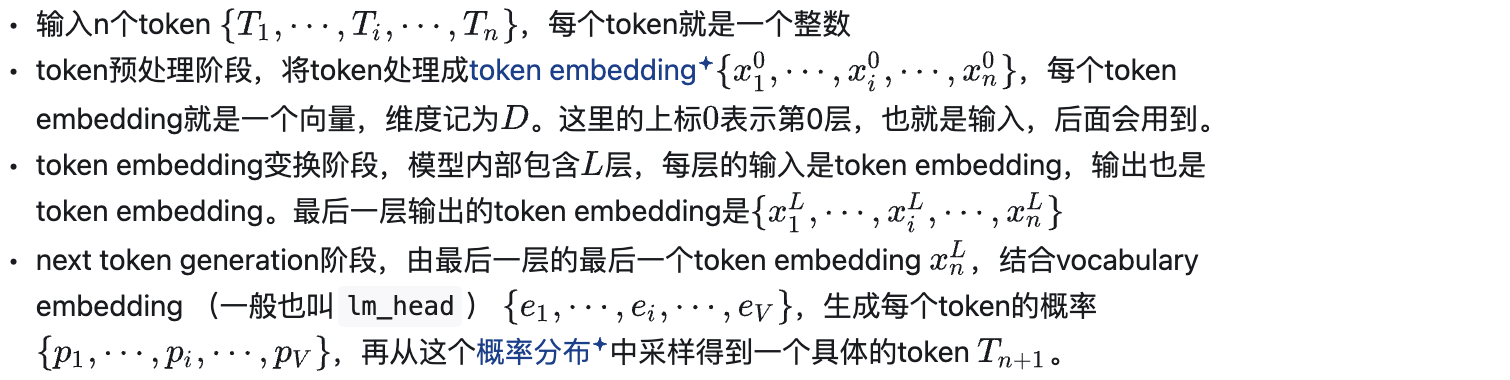

用一个流程图表示：
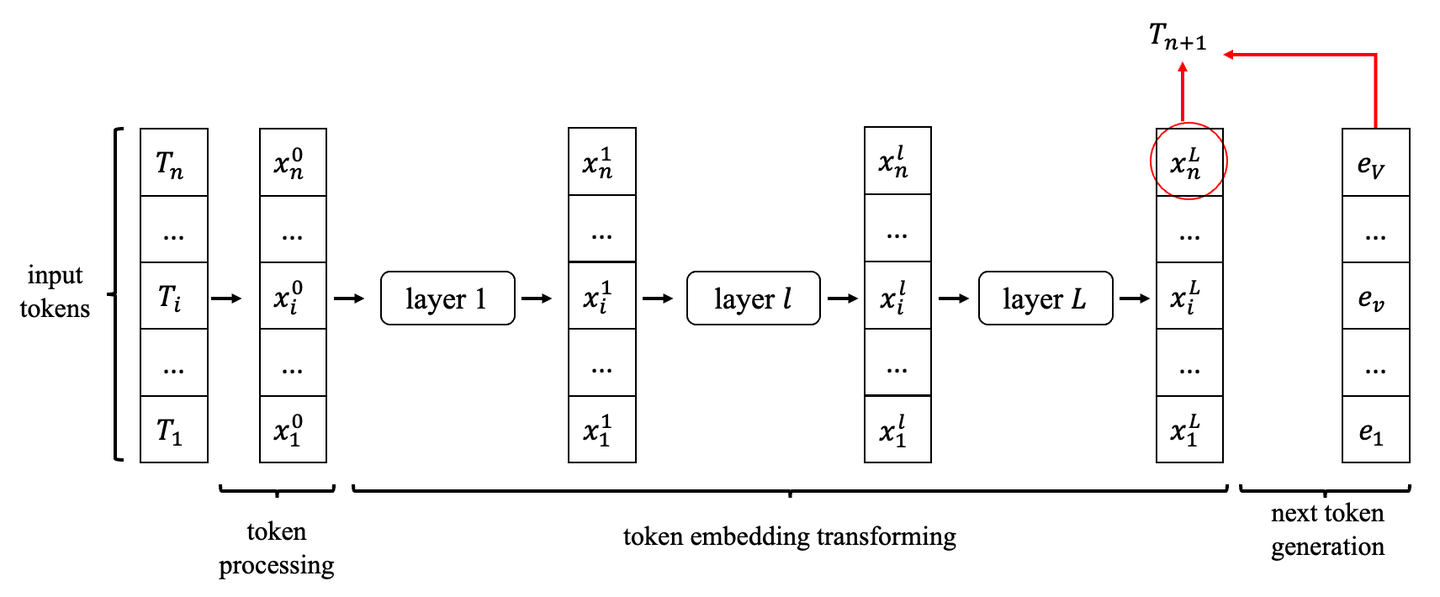

In [1]:
# 我们可以用简单的代码来验证上述结论：
import torch
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# text: "The quick brown fox jumps over the lazy"
tokens = [[464, 2068, 7586, 21831, 18045, 625, 262, 16931]]
input_n = torch.tensor(tokens)
output_n = model(input_ids=input_n, output_hidden_states=True)

# text: " dog"
tokens[0].append(3290)
input_n_plus_1 = torch.tensor(tokens)
output_n_plus_1 = model(input_ids=input_n_plus_1, output_hidden_states=True)

for i, (hidden_n, hidden_n_plus_1) in enumerate(zip(output_n.hidden_states, output_n_plus_1.hidden_states)):
    # hidden_n.shape is [1, 8, 768]  and hidden_n_plus_1.shape is [1, 9, 768]
    print(f"layer {i}, max difference {(hidden_n - hidden_n_plus_1[:, :-1, :]).abs().max().item()}")
    assert torch.allclose(hidden_n, hidden_n_plus_1[:, :-1, :], atol=1e-4)

/home/zhangfaen/miniconda3/envs/temp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zhangfaen/miniconda3/envs/temp/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


layer 0, max difference 0.0
layer 1, max difference 3.814697265625e-06
layer 2, max difference 3.814697265625e-06
layer 3, max difference 5.7220458984375e-06
layer 4, max difference 4.1961669921875e-05
layer 5, max difference 1.52587890625e-05
layer 6, max difference 1.9073486328125e-05
layer 7, max difference 2.09808349609375e-05
layer 8, max difference 7.62939453125e-06
layer 9, max difference 1.52587890625e-05
layer 10, max difference 1.52587890625e-05
layer 11, max difference 1.9073486328125e-05
layer 12, max difference 3.0517578125e-05


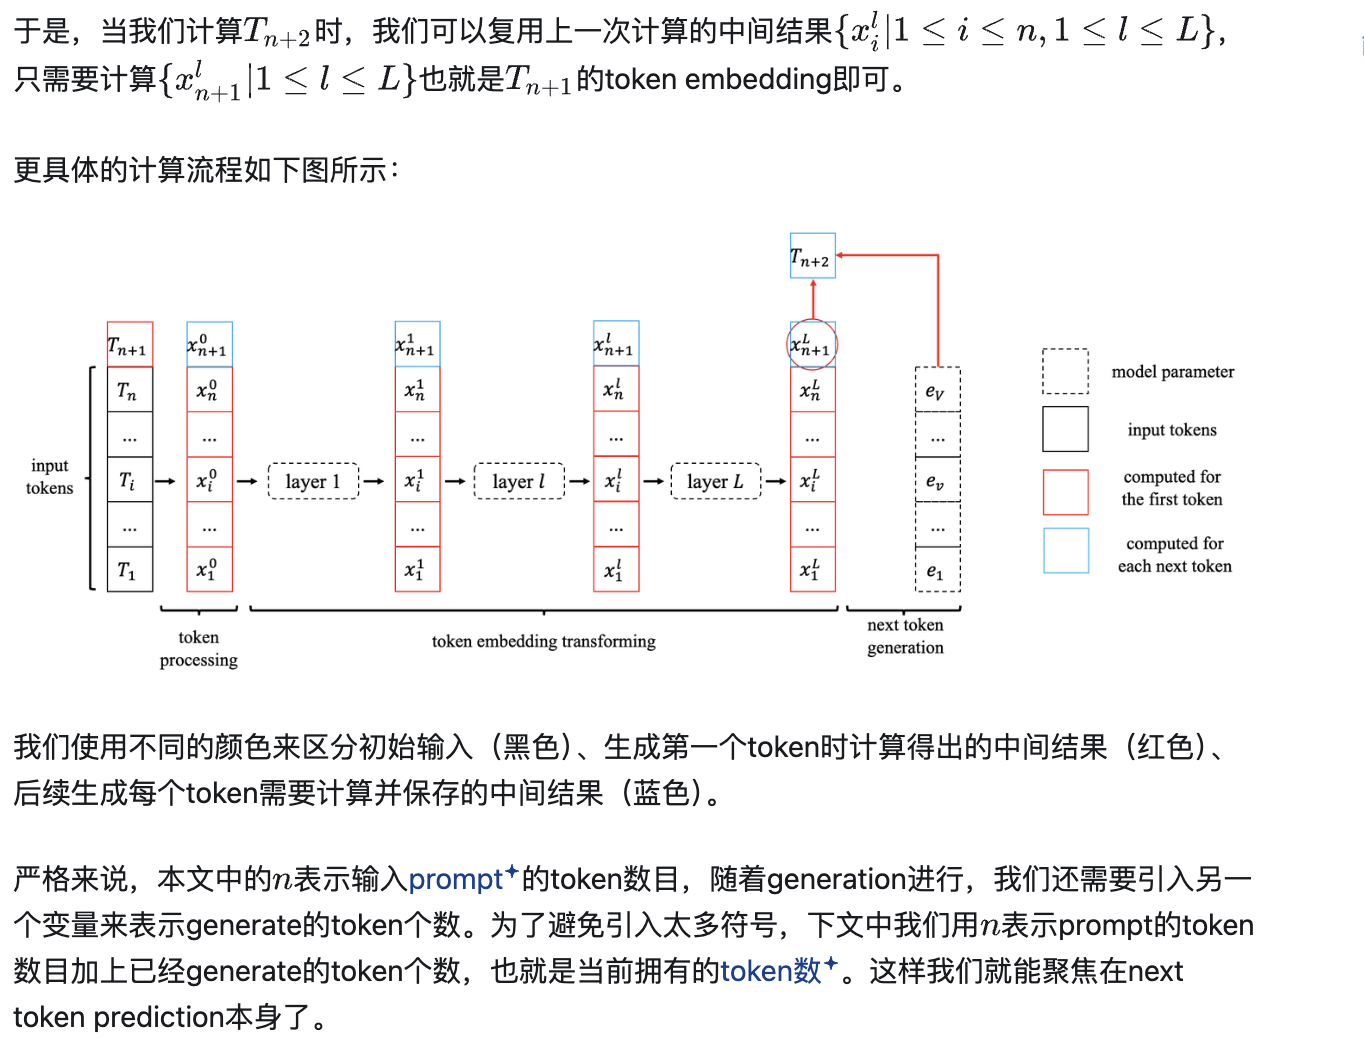

## 小插曲：神经网络计算的确定性
有些强迫症患者可能看到上述GPT2的代码输出非常不爽，毕竟还有大约
的误差。这里建议强迫症患者深呼吸一下，因为接下来的代码可能让他们更加震惊：

In [12]:
import torch
x = torch.randn(9990).abs()
z1 = x.sum().item()
z2 = x[:5000].sum().item() + x[5000:].sum().item()
print((z1 - z2 == 0)) # False

False


In [13]:
# 更有甚至，同一段代码执行多次的结果也可能不一样：
x = torch.randn(9990).abs()
indices = torch.randint(0, 9990, (9000,))

def f(x, indices):
    y = x.clone()
    y[indices] += x[:9000]
    return y

y1 = f(x, indices)
y2 = f(x, indices)
print((y1 - y2).abs().max().item() == 0) # False

# 这是因为indices里面有重复的元素，所以y[indices] += x[:9000]涉及并行竞争。
# 而并行的顺序一般是不确定的，所以这段代码的执行本身具有随机性。
# 一般来说，神经网络的计算并不会要求特别强的确定性，甚至不会要求特别高的精度，这也正是这几年算力突飞猛进的原因（使用低精度计算）。

False


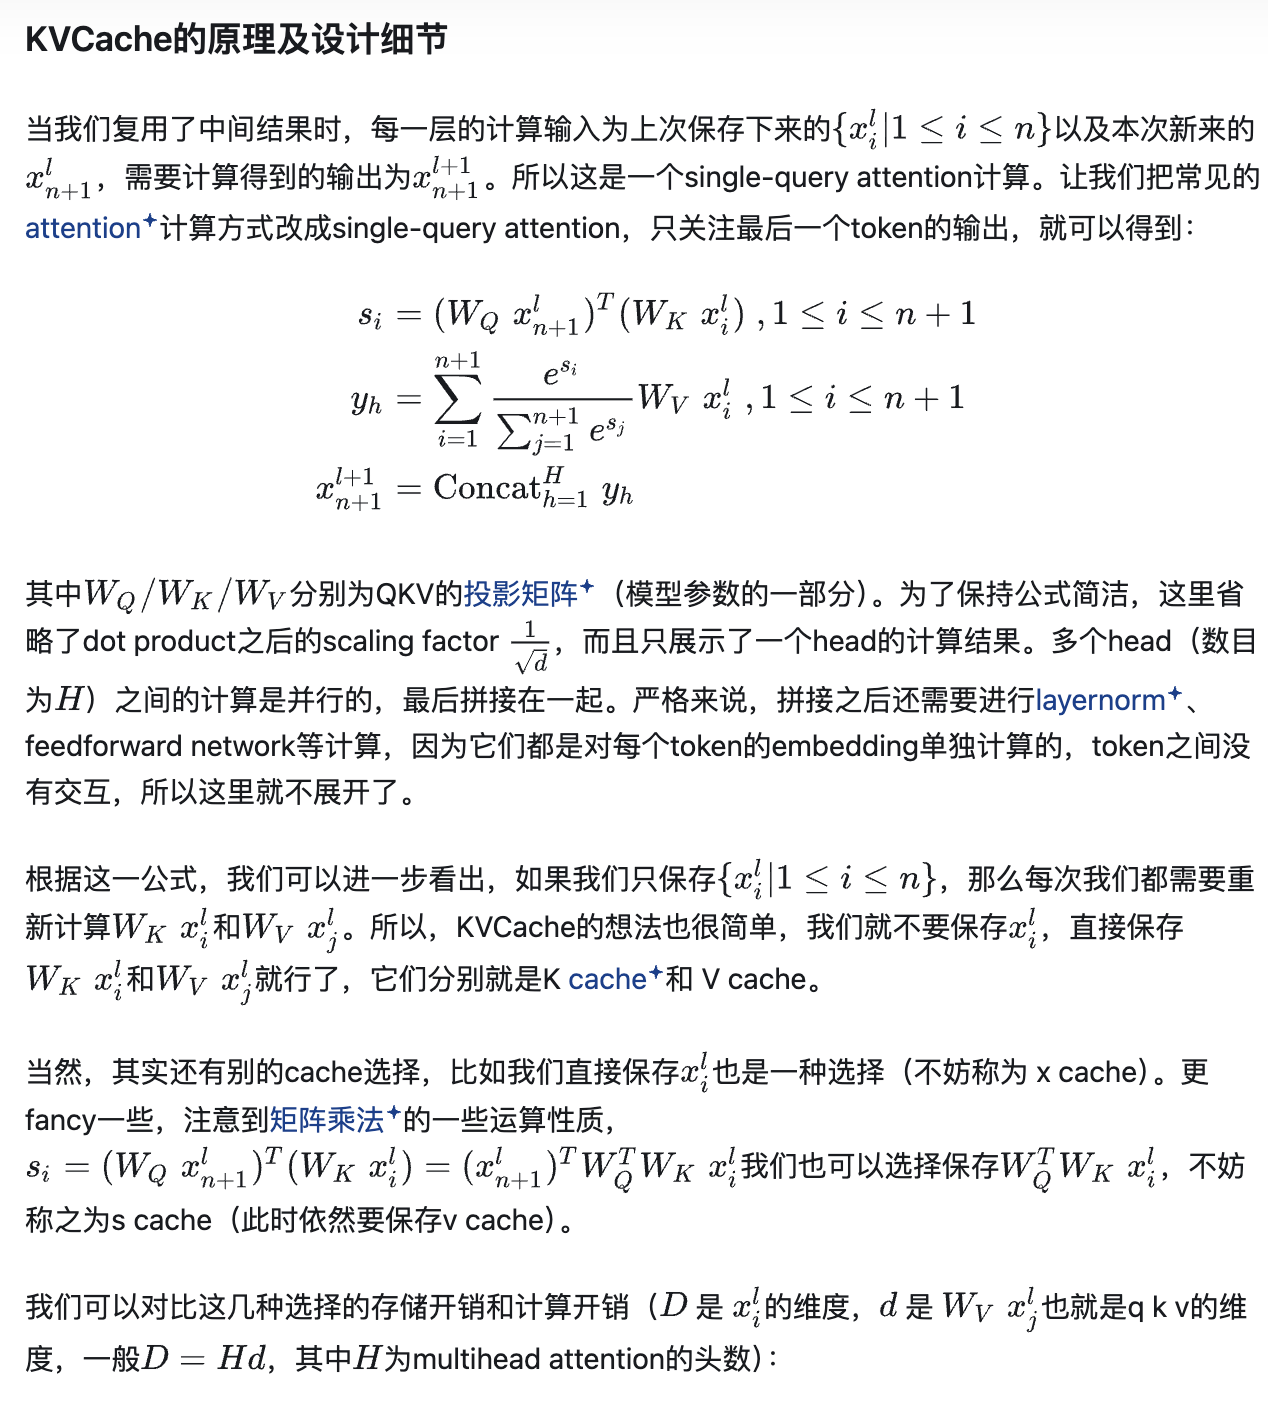
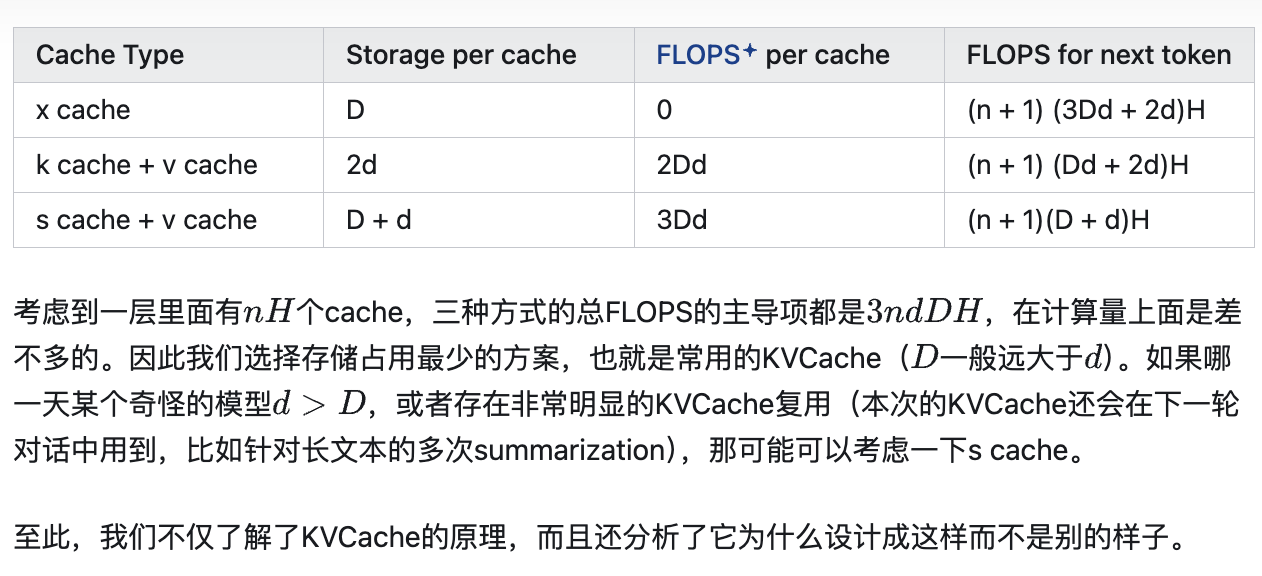

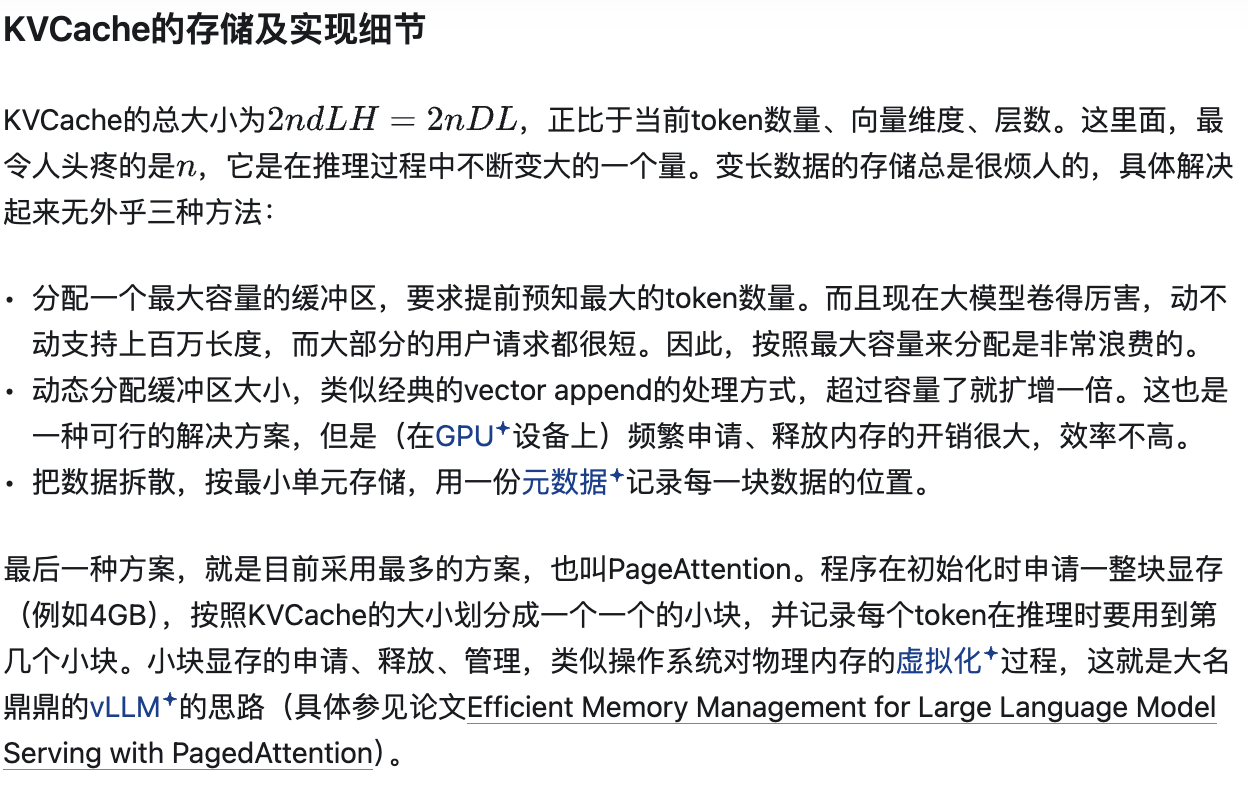

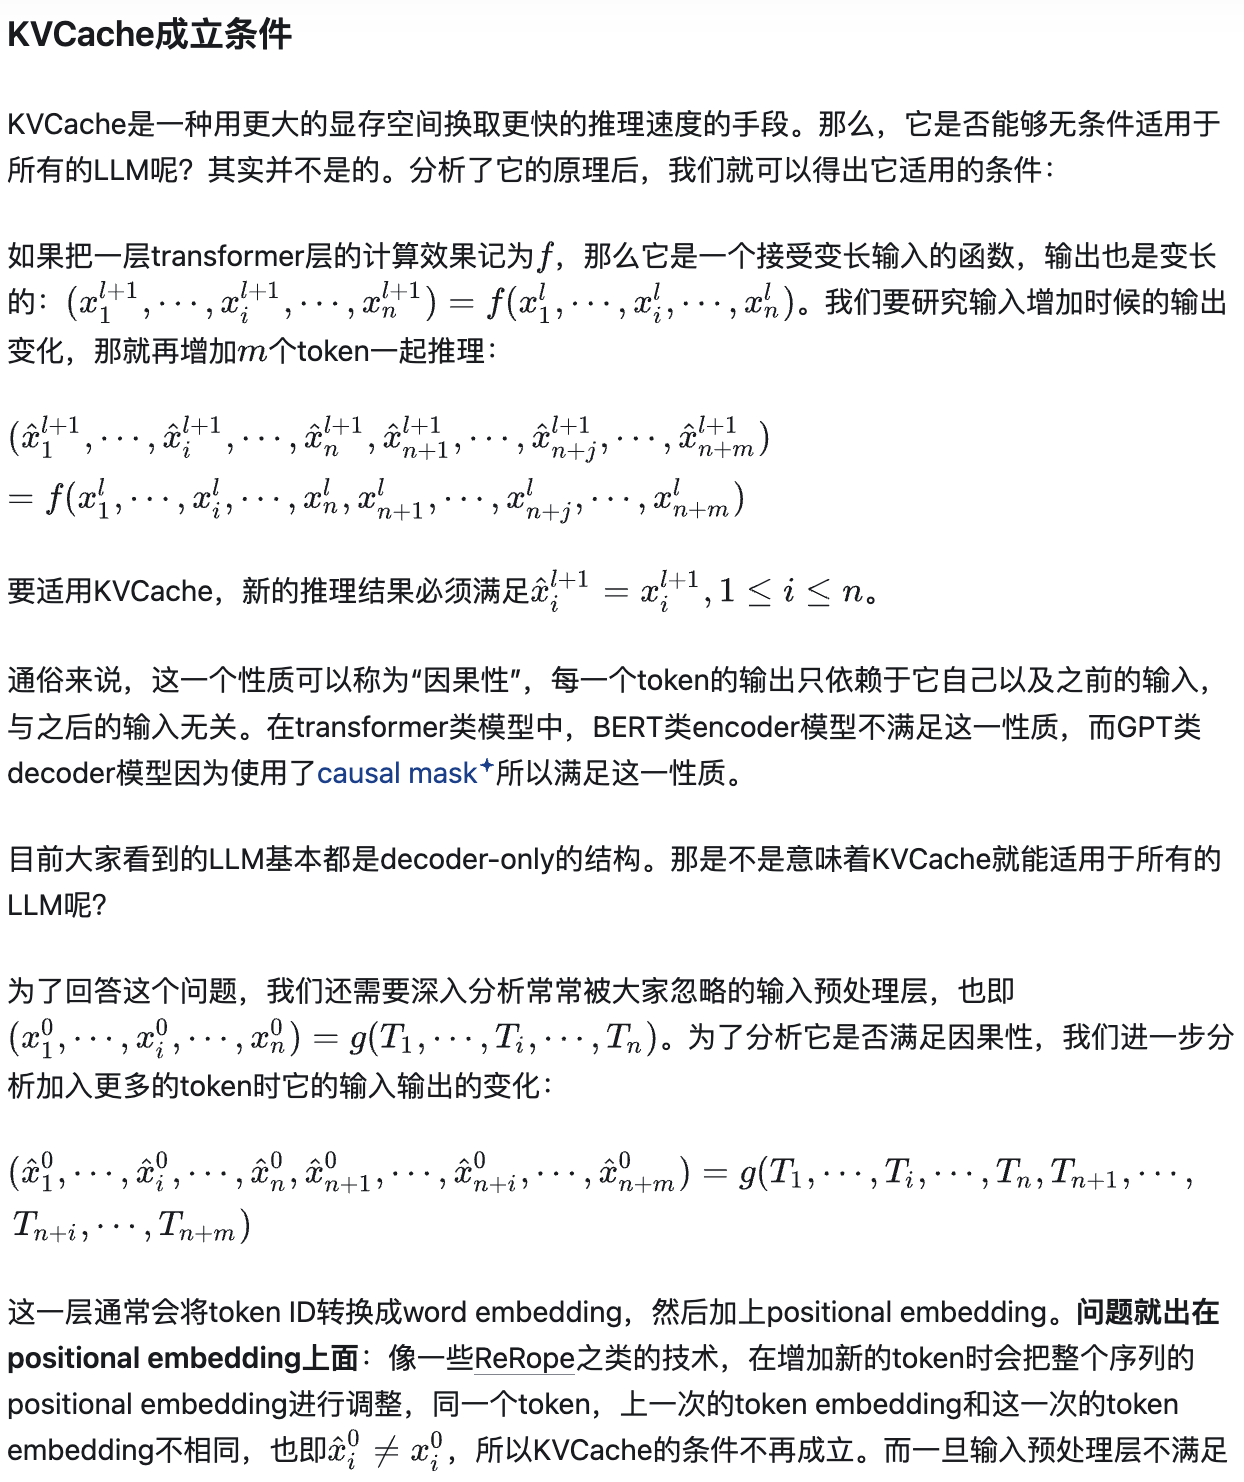
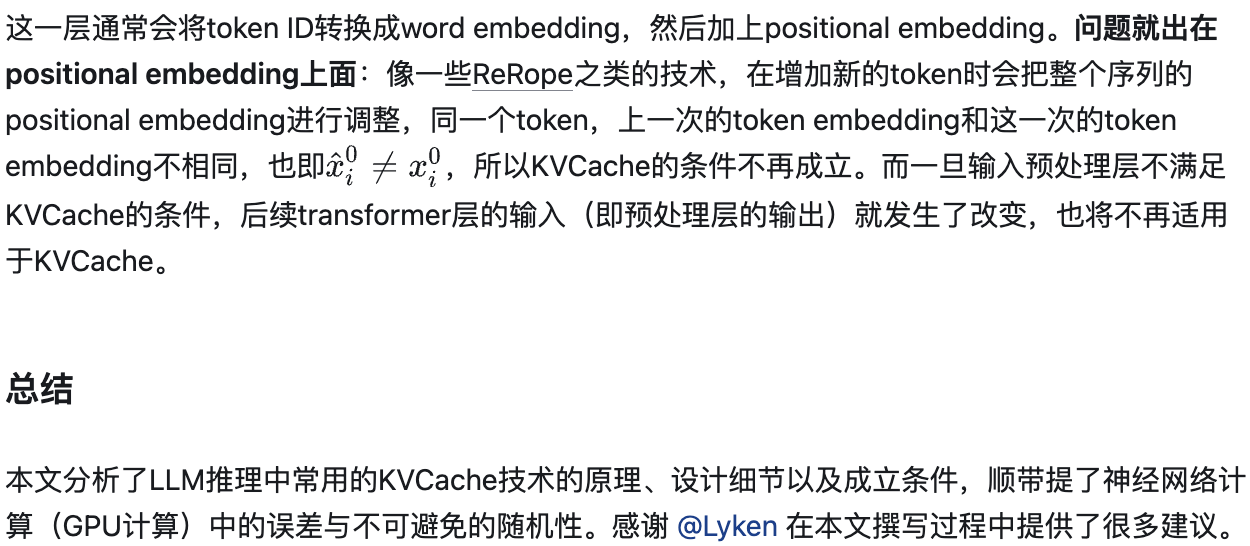